# Blackholes

Synthesizer has a collection of routines allowing us to also model the spectral energy distributions of black holes (i.e. AGN) and combine their emission with the emission of others galaxy components (i.e. stellar emission).

## Particle blackholes

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from synthesizer import galaxy
from synthesizer.blackhole_emission_models import UnifiedAGN
from synthesizer.particle import BlackHoles, Gas

# Set a random number seed to ensure consistent results
np.random.seed(42)

### Creating Particle Blackholes

Before generating some simple observational quantities from physical properties we first need to create a `BlackHoles` object. This object can be found in `synthesizer/particle/blackholes.py`. 

Lets create an instance of `BlackHoles` containing 4 fake black holes. To do so we can provide a number of optional keyword arguments but for now lets just provide their masses, metallicities, coordinates and accretion rates (the parameters required for spectra calculation). Note that `masses` and `accretion_rates` are positional arguments and must therefore always be provided for `particle.BlackHoles`, while `parametric.BlackHole`s have more flexibility (see the parametric black hole [docs](parametric_blackholes.ipynb)).

In [2]:
# Make fake properties
n = 4
masses = 10 ** np.random.uniform(low=7, high=9, size=n)  # Msun
coordinates = np.random.normal(0, 1.5, (n, 3))  # cMpc
accretion_rates = 10 ** np.random.uniform(
    low=-2, high=1, size=n
)  # Msun  # Msun / yr
metallicities = np.full(n, 0.01)

# And get the black holes object
bh = BlackHoles(
    masses=masses,
    coordinates=coordinates,
    accretion_rates=accretion_rates,
    metallicities=metallicities,
)

For some emission models we require an inclination. This could, in principle be calculated from the simulation and passed at instantiation, but for now we can use an in-built method to generate random inclinations.

In [3]:
bh.calculate_random_inclination()
print(bh.inclination)

[41.04629858 70.66583653 17.97064039 46.28109946] degree


#### Blackhole properties

On initialisation a handful of properties are automatically calculated if there prerequists are provided. For example, with `masses` and `accretion_rates` `bolometric_luminosities` ($ L_{\rm \bullet, bol} = \epsilon_{r}\dot{M}_{\bullet}c^{2} $) are automatically calcualted. Note that the radiative efficency (`epsilon`) defaults to 0.1 but can be passed as an array with a value for each particle. 

In [4]:
bh.bolometric_luminosities

unyt_array([3.87796015e+45, 1.48431556e+44, 4.26067691e+44, 7.11426744e+44], 'erg/s')

Here are some more examples of calculated properties.

In [5]:
print(bh.eddington_ratio)
print(bh.accretion_rate_eddington)
print(bh.eddington_luminosity)

[0.54977859 0.00148171 0.01164543 0.03593171]
[0.54977859 0.00148171 0.01164543 0.03593171]
[7.05367613e+45 1.00176047e+47 3.65866934e+46 1.97994099e+46] erg/s


As with most Synthesizer objects a summary of the object can be printed using `print`.

In [6]:
print(bh)

--------------------------------------------------------------------------------
                                SUMMARY OF BLACKHOLE                                
Number of blackholes: 4 
mass: [5.61151642e+07 7.96945482e+08 2.91063591e+08 1.57513205e+08] dimensionless 
accretion_rate: [0.685 0.026 0.075 0.126] dimensionless 
accretion_rate_eddington: [0.55  0.001 0.012 0.036] 
bolometric_luminosity: [3.87796015e+45 1.48431556e+44 4.26067691e+44 7.11426744e+44] dimensionless 
eddington_ratio: [0.55  0.001 0.012 0.036] 
bb_temperature: [272017.955  31926.706  68764.227 106257.824] dimensionless 
eddington_luminosity: [7.05367613e+45 1.00176047e+47 3.65866934e+46 1.97994099e+46] dimensionless 
epsilon: [0.1] 
inclination: [41.046 70.666 17.971 46.281] dimensionless 
cosine_inclination: [0.754 0.331 0.951 0.691] 



### Blackhole spectra and lines

Blackhole spectra (and lines) can be generated by combining the `BlackHoles` object with an emission model. An emission model translates the physical properties of the blackhole(s) (e.g. `mass`, `accretion_rate`, etc.) to an spectral energy distribution. These models are described in more detail in the [associated workbook](emission_models.ipynb).

In [7]:
# Define the emission model
grid_dir = "../../../tests/test_grid/"
emission_model = UnifiedAGN(
    disc_model="test_grid_agn", photoionisation_model="", grid_dir=grid_dir
)

To generate spectra we then simply call the `get_intrinsic_spectra` method which will return us an `Sed` object (see the `Sed` [docs](../sed.ipynb)) containing the intrinsic integrated spectra and will also store all the spectra that went into its creation in a `spectra` dictionary on the `BlackHoles` object.

In [8]:
# Generate the integrated spectra
spectra = bh.get_spectra_intrinsic(
    emission_model, verbose=True, grid_assignment_method="ngp"
)

/opt/hostedtoolcache/Python/3.10.14/x64/lib/python3.10/site-packages/unyt/array.py:1824: RuntimeWarning: overflow encountered in exp
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


Note that we can also include the effects of diffuse dust attenuation and emission. For details see the parametric black hole [docs](parametric_blackholes.ipynb).

We can now examine a single component, in this case the total intrinsic emission, using the `plot_spectra` helper method.

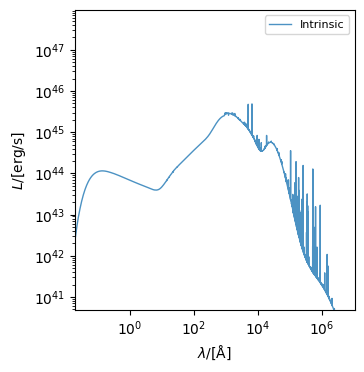

In [9]:
fig, ax = bh.plot_spectra(
    show=True,
    spectra_to_plot=[
        "intrinsic",
    ],
    quantity_to_plot="luminosity",
)

In addition to integrated spectra we can get a spectra per particle by calling the `get_particle_spectra_intrinsic` method. This will produce a 2D `Sed` containing the intrinsic spectra for each particle and store all created spectra in the `particle_spectra` dictionary on the `BlackHoles` object.

----------
SUMMARY OF SED 
Number of wavelength points: 8228 
Wavelength range: [0.00 Å,             299293000000.00 Å] 
log10(Peak luminosity/erg/(Hz*s)):             31.00 
log10(Bolometric luminosity/erg/s):[45.4196671  45.11227998 44.39826901 44.13897539]----------


/opt/hostedtoolcache/Python/3.10.14/x64/lib/python3.10/site-packages/unyt/array.py:1824: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


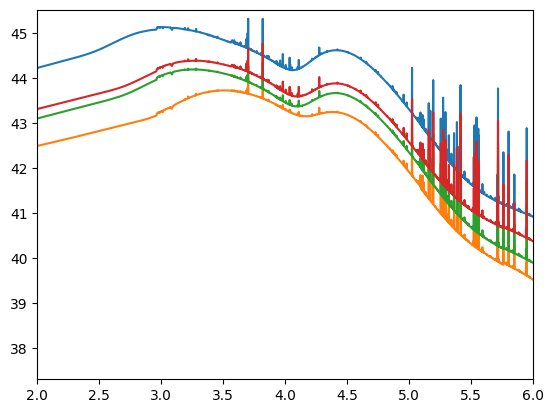

In [10]:
# Generate the particle spectra
spectra = bh.get_particle_spectra_intrinsic(
    emission_model, verbose=True, grid_assignment_method="ngp"
)

sed = bh.particle_spectra["intrinsic"]

print(sed)

plt.plot(np.log10(sed.lam), np.log10(sed.luminosity.T))
plt.ylim(
    np.max(np.log10(sed.luminosity)) - 8,
    np.max(np.log10(sed.luminosity)) + 0.2,
)
plt.xlim([2, 6])
plt.show()

#### Calculating black hole metallicity

If we want to calculate emission from the black hole we will need to know the metallicity of the emission regions surrounding the black hole. Above we could have passed an array of metallicities at instantiation but most of the time we will not know ahead of time what these values should be. Instead we can use the gas surrounding the black hole to calculate what this metallicity is. To do this we need to first create a `Galaxy` with both a `Gas` component and `BlackHoles`, again using fake data.

In [11]:
# Make fake gas properties
ngas = 200
ms = np.full(ngas, 10**6.5)  # Msun
pos = np.random.normal(0, 1.5, (ngas, 3))  # cMpc
hsml = np.full(ngas, 0.75)  # cMpc
metals = np.full(ngas, 0.01)

# And make the gas object
gas = Gas(
    masses=ms, metallicities=metals, coordinates=pos, smoothing_lengths=hsml
)

# And now create the galaxy
galaxy = galaxy(stars=None, gas=gas, black_holes=bh)

Now we have the galaxy we can use `galaxy.calculate_black_hole_metallicity()` to calculate the black holes' metallicity. This method will find all gas particles with smoothing lengths that intersect the black hole and calculate the mass weighted average of their metallicity. If a black hole does not find any gas neighbours then a default metallicity is set instead, by default this is solar metallicity (0.012) but can be overwritten by passing a new `default_metallicity` as shown below.

In [12]:
galaxy.calculate_black_hole_metallicity(default_metallicity=0.07)
print("Z_BH =", galaxy.black_holes.metallicities)

Z_BH = [0.01 0.01 0.01 0.07]
